# Training Neural Network for Pyrarucu
The goal here is to use a Multilayer Perceptron Regressor from Scikit Learn to output a value according to the position  

### Imports

In [40]:
import chess
import numpy as np
import pandas as pd
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MaxAbsScaler
import lightgbm
from random import random
import pickle
import matplotlib.pyplot as plt

### Bitboards

Here, we want to encode information about the FEN code to bitboards. So for each color and type of piece, we produce a bitboard and append it in a array. 

The obtained vector will be the entry of our Neural Network 

In [2]:
def bitboards_to_array(bb: np.ndarray) -> np.ndarray:
    bb = np.asarray(bb, dtype=np.uint64)[:, np.newaxis]
    s = 8 * np.arange(7, -1, -1, dtype=np.uint64)
    b = (bb >> s).astype(np.uint8)
    b = np.unpackbits(b, bitorder="little")
    return list(b)

In [3]:
def fen_to_bit_array(fen):
    board = chess.Board(fen=fen)

    black, white = board.occupied_co

    bitboards = np.array([
        black & board.pawns,
        black & board.knights,
        black & board.bishops,
        black & board.rooks,
        black & board.queens,
        black & board.kings,
        white & board.pawns,
        white & board.knights,
        white & board.bishops,
        white & board.rooks,
        white & board.queens,
        white & board.kings,
        board.turn,
        board.has_castling_rights(white),
        board.has_castling_rights(black)
    ], dtype=np.uint64)

    return bitboards_to_array(bitboards)


To use a neural network in our chess data, we should transform the FEN format to a more significative format. Here, we use Bitboards.

Imagine we want to represent the position of the black king in the 64 square board. We name this board the "Black King Bitboard" and write a 8x8 matrix where 1 represents a square the king occupies and 0 otherwise.

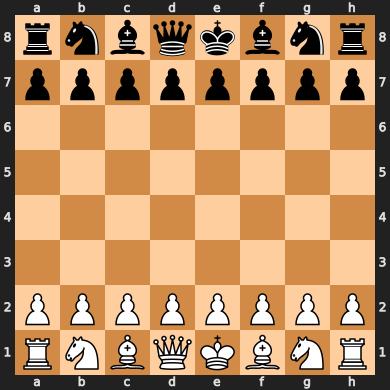

In [4]:
board = chess.Board()
board

In [5]:
black, white = board.occupied_co
np.array(bitboards_to_array([black & board.kings])).reshape(8, 8)

array([[0, 0, 0, 0, 1, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0]], dtype=uint8)

Every sequence of 0's and 1's is a binary number and can be represented as a int for facility. It is how we actually obtain the Black King bitboard

In [6]:
black & board.kings

1152921504606846976

### Dataset
[Available at kaggle](https://www.kaggle.com/datasets/ronakbadhe/chess-evaluations/?select=tactic_evals.csv)

This is a dataset containing around 16 million chess positions with a Stockfish evaluation at depth 22.

In [7]:
df = pd.read_csv('../data/random_evals.csv')
df.head()

,FEN,Evaluation
0,rnbqkb1r/pppppppp/B4n2/8/4P3/8/PPPP1PPP/RNBQK1...,-459
1,rnbqkb1r/pppppppp/5n2/1B6/4P3/8/PPPP1PPP/RNBQK...,-125
2,rnbqkbnr/p1pppppp/8/1p6/4P3/8/PPPP1PPP/RNBQKBN...,+198
3,rnbqkb1r/pppppppp/5n2/8/4P3/7N/PPPP1PPP/RNBQKB...,-155
4,rnbqkbnr/ppppp1pp/8/5p2/4P3/8/PPPP1PPP/RNBQKBN...,+209


This dataset contains chess positions in the FEN format.

We shall convert the FEN to our Bitboards encoding and train the network to output the evaluation 

In [8]:
df = df[~df['Evaluation'].str.contains('#')].reset_index(drop=True)
test_df = df[-20000:]
df = df[:20000]

In [9]:
X = df['FEN'].apply(fen_to_bit_array).to_list()
y = df['Evaluation']

In [10]:
X = np.array(X)

In [11]:
y = np.array(y).reshape(-1, 1)
scaler = MaxAbsScaler().fit(y)
y = scaler.transform(y)
y = y.reshape(-1, )
y

array([-0.05123912, -0.01395401,  0.02210315, ..., -0.00546997,
       -0.01730297, -0.00960036])

After some preprocessing, the data looks like this

In [56]:
print(X[:5], y[:5])

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]] [-0.05123912 -0.01395401  0.02210315 -0.01730297  0.0233311 ]


In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

In [58]:
reg = MLPRegressor().fit(X_train, y_train)

In [59]:
reg.predict(X_test)

array([ 0.07698299,  0.03236799,  0.00140006, ...,  0.05321622,
        0.0439213 , -0.01428812])

In [60]:
reg.score(X_test, y_test)

0.6739131692669325

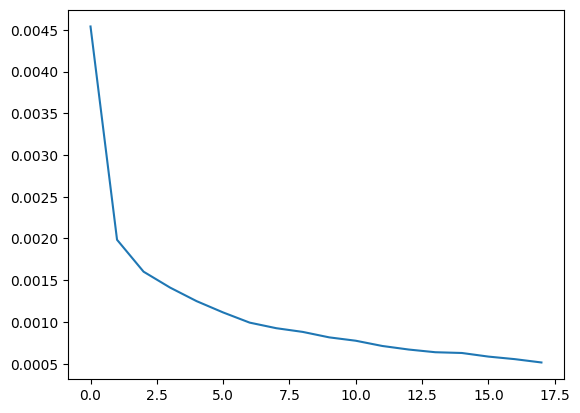

In [61]:
plt.plot(reg.loss_curve_)
# plt.plot(reg.validation_scores_)

# Visualizing real positions

In [45]:
size_df = len(test_df)

FEN           2k5/p6p/1p4p1/8/8/4B1P1/PPP2P1P/2K5 b - - 1 28
Evaluation                                              +821
Name: 938182, dtype: object


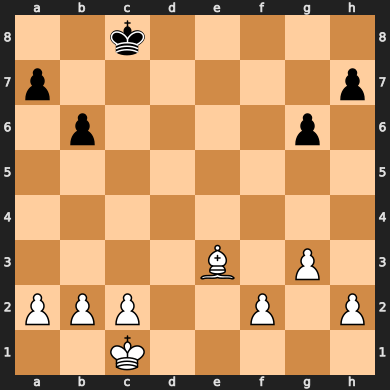

In [78]:
pos = test_df.iloc[int(size_df * random())]
print(pos)
evaluation = scaler.transform([[pos['Evaluation']]])[0][0]
fen = pos['FEN']
bitboard = fen_to_bit_array(fen)
board = chess.Board(fen)
board

In [79]:
prediction = reg.predict([bitboard])
prediction[0]

0.057292581524005265

In [80]:
scaler.inverse_transform([prediction])

array([[513.22694529]])

### Saving the model

In [62]:
filename = '../engines/model.pkl'
pickle.dump(reg, open(filename, 'wb'))

We can retrive the saved model with

In [54]:
loaded_model = pickle.load(open(filename, 'rb'))

In [55]:
prediction = loaded_model.predict([bitboard])
prediction[0]

-0.049731137619364846

In [57]:
loaded_model.score(X_test, y_test)

0.6862862988136478